# MIXED PRECISION for yolov8

In [1]:
import cv2
import glob
import os
import numpy as np
import random
import shutil
import sys
import matplotlib.pyplot as plt
from bokeh import plotting
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import math
from IPython.display import Image, display

# Setting up essential Paths

<ul>
    <li>Before running below block set 'SNPE_ROOT' to your snpe folder path</li>
    <li>Also, set 'DEVICE_ID' to your device-id. Use command "adb devices" to get devices names.</li>
    </ul>

In [2]:
## Give appropriate permission to the directory "FOLDER_WITH_ARTIFACTS" you are working with
os.environ['SNPE_ROOT']="/local/mnt/workspace/sdks/snpe/snpe-2.10.0.4541"#snpe-2.7.0.4264,snpe-2.11.0.230603"
os.environ['DEVICE_ID']="b809ee77" #fill your device-id. Use command "adb devices" to get devices names. example :"e18d5d0"
os.environ['RAW_FILE_FOLDER']="raw"#rawfiles
os.environ['FOLDER_WITH_ARTIFACTS']="MIXED_PRECISION"
os.environ['DLC32']="dlc/yolov8.dlc"
os.environ['DLC8']="dlc/yolov8Q.dlc"
os.environ['TARGET_INPUT_LIST']="list.txt"
os.environ['ONDEVICE_FOLDER']="yolov8_comparision"
os.environ['DEVICE_HOST']="localhost"
os.environ['SNPE_TARGET_ARCH']="x86_64-linux-clang" #for host machine for dlc creation
os.environ['SNPE_TARGET_STL']="libc++_shared.so"

# Preparing test data to run on device using DLC
* Using COCO Dataset for accuracy measurement<br>
* Download COCO2017 validation dataset.
* put all labels in <b>MIXED_PRECISION\labels</b>. Lables are not required for this pipeline and are completely optional.
* put all images in <b>MIXED_PRECISION\val2017</b>

In [3]:
%%bash
mkdir -p raw
mkdir -p dlc
mkdir -p dlc/quantization_raw
mkdir -p new_raw

In [4]:
# # dataset is big to be run faster on device. For tht reason deleting images. 
# files = os.listdir('val2017')
# for file in files[1000:]:
#     os.remove("val2017/"+file)

In [5]:
# # removing file for which jpg is there but lables are not available

# for file in os.listdir("val2017"):
#     if ".jpg" in file and not os.path.exists("labels/"+file.replace(".jpg",".txt")):
#         os.remove("val2017/"+file)
        
# # removing file for which lable is there but jpg are not available
# for file in os.listdir("labels/"):
#     if ".txt" in file and not os.path.exists("val2017/"+file.replace(".txt",".jpg")):
#         os.remove("labels/"+file)

# Pre-processing

In [6]:
def preprocess(original_image):
    resized_image = cv2.resize(original_image, (640, 640))
    resized_image = resized_image/255
    return resized_image

def save_raw(imgfile,i):
    origimg = cv2.imread(imgfile)
    img = preprocess(origimg)
    img = img.astype(np.float32)
    img.tofile("raw/"+filenames[i].split(".")[0]+".raw")

In [7]:
filenames = os.listdir("val2017")
for i in range(0,len(filenames)):
    if "jpg" in filenames[i].lower():
        save_raw("val2017/"+filenames[i],i)
    else:
        print("Could not get this image pre-processed")
        print(" ==> filename :: ",filenames[i].lower())

In [8]:
## preparing input for quantization
list_quant_images = random.sample(os.listdir("raw"),30)
# list_quant_images=['000000419379.raw', '000000224807.raw', '000000349860.raw',
#                    '000000116439.raw', '000000456865.raw', '000000034873.raw',
#                    '000000115885.raw', '000000482970.raw', '000000322864.raw',
#                    '000000183246.raw', '000000191580.raw', '000000175438.raw',
#                    '000000378453.raw', '000000335081.raw', '000000555972.raw',
#                    '000000519522.raw', '000000200421.raw', '000000408774.raw',
#                    '000000064523.raw', '000000073326.raw', '000000243075.raw',
#                    '000000249129.raw', '000000137950.raw', '000000319617.raw',
#                    '000000297427.raw', '000000127476.raw', '000000497867.raw',
#                    '000000562843.raw', '000000270297.raw', '000000387098.raw']
print(list_quant_images)
for img in list_quant_images:
    shutil.copy("raw/"+img, "dlc/quantization_raw")

['000000523807.raw', '000000312263.raw', '000000298904.raw', '000000096960.raw', '000000508101.raw', '000000413552.raw', '000000559348.raw', '000000363666.raw', '000000579902.raw', '000000581317.raw', '000000210099.raw', '000000235836.raw', '000000378453.raw', '000000493613.raw', '000000534270.raw', '000000370375.raw', '000000146498.raw', '000000112997.raw', '000000040757.raw', '000000146363.raw', '000000437205.raw', '000000569825.raw', '000000562243.raw', '000000502168.raw', '000000087144.raw', '000000157138.raw', '000000511453.raw', '000000216277.raw', '000000105249.raw', '000000121591.raw']


In [9]:
%%bash
cd dlc
find . -name *.raw > quantization_input_list.txt

# ONNX to dlc and quantized dlc cnversion

In [10]:
%%bash
export LD_LIBRARY_PATH=$SNPE_ROOT/lib/$SNPE_TARGET_ARCH:$LD_LIBRARY_PATH
export PATH=$SNPE_ROOT/bin/$SNPE_TARGET_ARCH::$PATH
export PYTHONPATH=$SNPE_ROOT/lib/python:$PYTHONPATH
export ONNX_DIR="/local/mnt/workspace/env/aimet_126/lib/python3.8/site-packages/onnx"
$SNPE_ROOT/bin/$SNPE_TARGET_ARCH/snpe-net-run --version

snpe-onnx-to-dlc --input_network "onnx_model/yolov8n_11.onnx" --output_path "dlc/yolov8.dlc"
cd dlc
snpe-dlc-quantize --input_dlc yolov8.dlc --output_dlc yolov8Q.dlc --input_list quantization_input_list.txt --enable_htp
snpe-dlc-viewer -i yolov8Q.dlc -s yolov8Q_viewer.html

SNPE v2.10.0.4541
     0.1ms [  INFO ] Initializing logging in the backend. Callback: [0xc9b6a0], Log Level: [3]
     0.1ms [  INFO ] No BackendExtensions lib provided;initializing NetRunBackend Interface
   352.8ms [  INFO ] cleaning up resources for input tensors
   353.0ms [  INFO ] cleaning up resources for output tensors
   696.6ms [  INFO ] cleaning up resources for input tensors
   696.6ms [  INFO ] cleaning up resources for output tensors
  1053.0ms [  INFO ] cleaning up resources for input tensors
  1053.0ms [  INFO ] cleaning up resources for output tensors
  1432.7ms [  INFO ] cleaning up resources for input tensors
  1432.7ms [  INFO ] cleaning up resources for output tensors
  1859.7ms [  INFO ] cleaning up resources for input tensors
  1859.7ms [  INFO ] cleaning up resources for output tensors
  2285.4ms [  INFO ] cleaning up resources for input tensors
  2285.4ms [  INFO ] cleaning up resources for output tensors
  2708.3ms [  INFO ] cleaning up resources for input tens

2023-07-20 13:09:41,264 - 214 - INFO - Successfully simplified the onnx model in child process
2023-07-20 13:09:41,316 - 214 - INFO - Successfully receive the simplified onnx model in main process
2023-07-20 13:09:41,901 - 214 - INFO - INFO_INITIALIZATION_SUCCESS: 
2023-07-20 13:09:41,948 - 214 - INFO - INFO_CONVERSION_SUCCESS: Conversion completed successfully
2023-07-20 13:09:41,968 - 214 - INFO - INFO_WRITE_SUCCESS: 
[INFO] InitializeStderr: DebugLog initialized.
[INFO] Processed command-line arguments
[INFO] Quantized parameters
[INFO] Generated activations
[INFO] Saved quantized dlc to: yolov8Q.dlc
[INFO] DebugLog shutting down.
[INFO] InitializeStderr: DebugLog initialized.
[INFO] SNPE HTP Offline Prepare: Attempting to create cache for SM8550
[INFO] Attempting to open dynamically linked lib: libHtpPrepare.so
[INFO] dlopen libHtpPrepare.so SUCCESS handle 0x30e02f0
[INFO] Found Interface Provider (v2.5)
[USER_INFO] Offline Prepare VTCM size(MB) selected = 8
[USER_INFO] BackendTerm

# Creating Bin and Lib Folder on Device 

In [11]:
os.environ['SNPE_TARGET_ARCH']="aarch64-android-clang8.0"#changing arch for running dlc on device.

In [12]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "mkdir -p /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/bin" && $DEVICE_SHELL shell "mkdir -p /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/lib" && $DEVICE_SHELL shell "mkdir -p /data/local/tmp/snpeexample/dsp/lib"

# Pushing all Lib and Bin files onto Device

In [13]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push $SNPE_ROOT/lib/$SNPE_TARGET_ARCH/$SNPE_TARGET_STL /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/lib
$DEVICE_SHELL push $SNPE_ROOT/bin/$SNPE_TARGET_ARCH/snpe-net-run /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/bin
$DEVICE_SHELL push $SNPE_ROOT/lib/dsp/* /data/local/tmp/snpeexample/dsp/lib
# hexagon-v73/unsigned/*
$DEVICE_SHELL push $SNPE_ROOT/lib/$SNPE_TARGET_ARCH/*.so /data/local/tmp/snpeexample/$SNPE_TARGET_ARCH/lib

/local/mnt/workspace/sdks/snpe/snpe-2.10.0.4541/lib/aarch64-android-clang8.0/libc++_shared.so: 1 file pushed, 0 skipped. 432.4 MB/s (6835688 bytes in 0.015s)
/local/mnt/workspace/sdks/snpe/snpe-2.10.0.4541/bin/aarch64-android-clang8.0/snpe-net-run: 1 file pushed, 0 skipped. 193.2 MB/s (393240 bytes in 0.002s)
/local/mnt/workspace/sdks/snpe/snpe-2.10.0.4541/lib/dsp/libcalculator_skel.so: 1 file pushed, 0 skipped. 167.6 MB/s (7348 bytes in 0.000s)
/local/mnt/workspace/sdks/snpe/snpe-2.10.0.4541/lib/dsp/libSnpeDspV65Skel.so: 1 file pushed, 0 skipped. 319.7 MB/s (2218216 bytes in 0.007s)
/local/mnt/workspace/sdks/snpe/snpe-2.10.0.4541/lib/dsp/libSnpeDspV66Skel.so: 1 file pushed, 0 skipped. 321.3 MB/s (2342992 bytes in 0.007s)
/local/mnt/workspace/sdks/snpe/snpe-2.10.0.4541/lib/dsp/libSnpeHtpV68Skel.so: 1 file pushed, 0 skipped. 325.4 MB/s (6559328 bytes in 0.019s)
/local/mnt/workspace/sdks/snpe/snpe-2.10.0.4541/lib/dsp/libSnpeHtpV69Skel.so: 1 file pushed, 0 skipped. 242.2 MB/s (7944816 byt

# Pushing Artifacts on to Device

In [14]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell "mkdir -p /data/local/tmp/$ONDEVICE_FOLDER"

In [15]:
inference_file_name = "raw/img1.raw"
## comment above line and enable below line to select inference image from coco dataset.
## right now we are using an image of our own
# inference_file_name = "raw/"+random.sample(os.listdir("raw"),1)[0] #./new_raw/000000387098.raw
print(inference_file_name)
shutil.copy(inference_file_name,"new_raw")

raw/img1.raw


'new_raw/img1.raw'

In [16]:
%%bash
find ./new_raw -name *.raw > list.txt
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push $DLC32 /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $DLC8 /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push new_raw /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $TARGET_INPUT_LIST /data/local/tmp/$ONDEVICE_FOLDER

dlc/yolov8.dlc: 1 file pushed, 0 skipped. 114.1 MB/s (12897157 bytes in 0.108s)
dlc/yolov8Q.dlc: 1 file pushed, 0 skipped. 242.9 MB/s (7258710 bytes in 0.028s)
new_raw/: 1 file pushed, 0 skipped. 157.2 MB/s (4915200 bytes in 0.030s)
list.txt: 1 file pushed, 0 skipped. 0.1 MB/s (19 bytes in 0.000s)


# Inferencing on target device using 8 bit DLC on DSP Runtime and FP32 DLC on CPU
* Give name of DLC in OUTPUT_DLC_QUANTIZED8 and ondevice folder

In [17]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/data/local/tmp/snpeexample/aarch64-android-clang8.0/lib
export PATH=$PATH:/data/local/tmp/snpeexample/aarch64-android-clang8.0/bin
export OUTPUT_FOLDER=OUTPUT_8b_DSP
export OUTPUT_FOLDER_FP32=OUTPUT_FP32_CPU
export OUTPUT_DLC_QUANTIZED8=yolov8Q.dlc
export OUTPUT_DLC_FP32=yolov8.dlc
export ADSP_LIBRARY_PATH="/data/local/tmp/snpeexample/dsp/lib;/system/lib/rfsa/adsp;/system/vendor/lib/rfsa/adsp;/dsp"
export ONDEVICE_FOLDER="yolov8_comparision"

cd /data/local/tmp/$ONDEVICE_FOLDER &&
snpe-net-run --container $OUTPUT_DLC_FP32 --input_list list.txt --output_dir $OUTPUT_FOLDER_FP32 --debug
snpe-net-run --container $OUTPUT_DLC_QUANTIZED8 --input_list list.txt --output_dir $OUTPUT_FOLDER --use_dsp --debug

-------------------------------------------------------------------------------
Model String: N/A
SNPE v2.10.0.4541
-------------------------------------------------------------------------------
Processing DNN input(s):
./new_raw/img1.raw
Successfully executed!
-------------------------------------------------------------------------------
Model String: N/A
SNPE v2.10.0.4541
-------------------------------------------------------------------------------
Processing DNN input(s):
./new_raw/img1.raw
Successfully executed!


# Pulling Output folder generated on different precision and runtimes

In [18]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_8b_DSP OUTPUT_8b_DSP
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_FP32_CPU OUTPUT_FP32_CPU

/data/local/tmp/yolov8_comparision/OUTPUT_8b_DSP/: 249 files pulled, 0 skipped. 38.1 MB/s (256645240 bytes in 6.426s)
/data/local/tmp/yolov8_comparision/OUTPUT_FP32_CPU/: 249 files pulled, 0 skipped. 35.4 MB/s (256637976 bytes in 6.920s)


In [19]:
label2class = {'0': 'person', '1': 'bicycle', '2': 'car', '3': 'motorcycle', '4': 'airplane', '5': 'bus', 
               '6': 'train', '7': 'truck', '8': 'boat', '9': 'traffic', '10': 'fire', '11': 'stop', '12': 'parking', 
               '13': 'bench', '14': 'bird', '15': 'cat', '16': 'dog', '17': 'horse', '18': 'sheep', '19': 'cow', 
               '20': 'elephant', '21': 'bear', '22': 'zebra', '23': 'giraffe', '24': 'backpack', '25': 'umbrella', 
               '26': 'handbag', '27': 'tie', '28': 'suitcase', '29': 'frisbee', '30': 'skis', '31': 'snowboard', 
               '32': 'sports', '33': 'kite', '34': 'baseball', '35': 'baseball', '36': 'skateboard', '37': 'surfboard', 
               '38': 'tennis', '39': 'bottle', '40': 'wine', '41': 'cup', '42': 'fork', '43': 'knife', '44': 'spoon', 
               '45': 'bowl', '46': 'banana', '47': 'apple', '48': 'sandwich', '49': 'orange', '50': 'broccoli', 
               '51': 'carrot', '52': 'hot', '53': 'pizza', '54': 'donut', '55': 'cake', '56': 'chair', '57': 'couch', 
               '58': 'potted', '59': 'bed', '60': 'dining', '61': 'toilet', '62': 'tv', '63': 'laptop', '64': 'mouse', 
               '65': 'remote', '66': 'keyboard', '67': 'cell', '68': 'microwave', '69': 'oven', '70': 'toaster', 
               '71': 'sink', '72': 'refrigerator', '73': 'book', '74': 'clock', '75': 'vase', '76': 'scissors', 
               '77': 'teddy', '78': 'hair', '79': 'toothbrush'}

print(list(label2class.values()))

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic', 'fire', 'stop', 'parking', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports', 'kite', 'baseball', 'baseball', 'skateboard', 'surfboard', 'tennis', 'bottle', 'wine', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted', 'bed', 'dining', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy', 'hair', 'toothbrush']


In [20]:
from matplotlib import pyplot as plt
import cv2.dnn
import numpy as np

colors = np.random.uniform(0, 255, size=(len(list(label2class.values())), 3))

def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = f'{label2class[str(class_id)]} ({confidence:.2f})'
    color = colors[class_id]
    img = cv2.rectangle(img, (x, y), (x_plus_w, y_plus_h), color, 2)
    img = cv2.putText(img, label, (x +2, y -10), cv2.FONT_HERSHEY_TRIPLEX, 0.5, color, 2)
    return img

In [21]:
def post_proc(output, originalImagePath, save_img_path):
    print(originalImagePath)
    original_image: np.ndarray = cv2.imread(originalImagePath)
    ratio_1 = original_image.shape[0]/640
    ratio_2 = original_image.shape[1]/640
    boxes = []
    scores = []
    class_ids = []
    for i in range(0, output.shape[0]):
        classes_scores = output[i][4:]
        (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
        if maxScore >= 0.05:
            x = round(output[i][0]) ; y = round(output[i][1]); 
            w = round(output[i][2]) ; h = round(output[i][3]);
            x1, y1 = round(x- (w/2) ), round(y- (h/2) )
            x2, y2 = round(x+ (w/2) ), round(y+ (h/2) )
            box = [x1, y1, x2, y2]
            boxes.append(box)
            scores.append(float(maxScore))
            class_ids.append(maxClassIndex)
    
    result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.20, 0.5, 0.5) #32b CPU
    detections = []
    img = original_image
    for i in range(len(result_boxes)):
        index = result_boxes[i]
        box = boxes[index]
        detection = {
            'class_id': class_ids[index],
            'class_name': label2class[str(class_ids[index])],
            'confidence': scores[index],
            'box': box
             }
        detections.append(detection)
        img = draw_bounding_box(original_image, class_ids[index], scores[index], int(box[0]*ratio_2), int(box[1]*ratio_1), int(box[2]*ratio_2), int(box[3]*ratio_1))
#     print(detections)
    cv2.imwrite(save_img_path, img)
    str_pred = ""
    for dic in detections:
#         print(dic['class_name']+" "+str(dic['box'][0])+" "+str(dic['box'][1])+" "+str(dic['box'][2])+" "+str(dic['box'][3]))
        str_pred+= dic['class_name']+" "+str(dic['confidence'])+" "+str(dic['box'][0])+" "+str(dic['box'][1])+" "+str(dic['box'][2])+" "+str(dic['box'][3])+"\n"
    return str_pred.strip()

* Below block showing results for int8 dlc.
* the output of yolov8 is 8400 X 84
* It means in an image it can identify max 8400 subjects and along with each subject there are 4 {coordinates} + 80  {class probabilities}
* to analyse further print output[0][4:], output[0][4:]......output[8400][4:], probability scores are 0 for all.

# Clearlly, int8 did not yield good results
### Probability scores are 0, using int8 dlc. Visualization of output can be seen by running below blocks.

In [22]:
output_folder = "OUTPUT_8b_DSP/Result_0"
output = np.fromfile(output_folder+'/output0.raw', dtype="float32")
output = np.transpose(output.reshape((84,8400)).astype(np.float32) )
print(output[0][4:])
print(inference_file_name)
originalImagePath = inference_file_name.replace(".raw",".jpg").replace("raw","val2017")
print(originalImagePath)
runtime = output_folder.split("_")[-1]
save_img_path = output_folder+"/"+inference_file_name.split("/")[-1].replace(".raw",".jpg")

label_and_coordinates = post_proc(output, originalImagePath, save_img_path)

print("prediction :: ",label_and_coordinates)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
raw/img1.raw
val2017/img1.jpg
val2017/img1.jpg
prediction ::  


INPUT


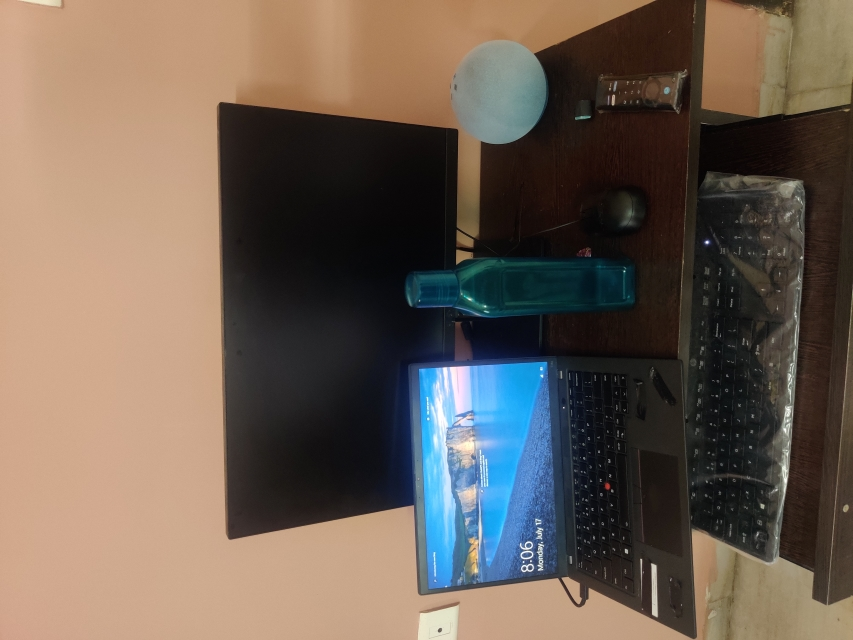

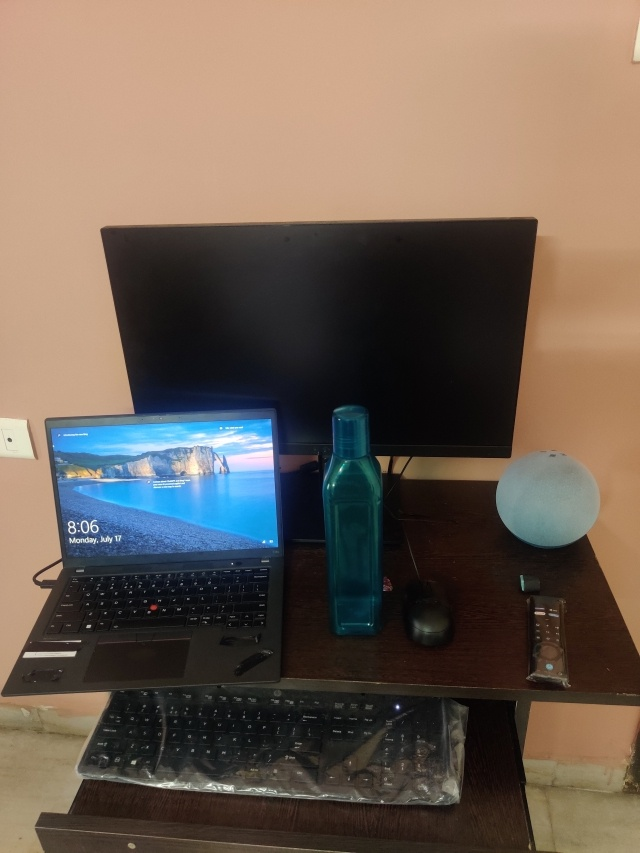


OUTPUT


In [23]:
print("INPUT")
display(Image(filename=originalImagePath))
print("\n=========================================\nOUTPUT")
display(Image(filename=save_img_path))

# MIXED PRECISION DLC
* below part of the code deals with mixed precision dlc creation and execution on dsp runtime.
* Below code uses functions defined above in this notebook. So, it is recommended to run entire notbook

# Code to plot the similarity score layer by layer for int8 and fp32 dlc

In [24]:
def cosine_sim(out_a, out_b):
    """
    This function computes the cosine similarity of two outputs.
    :param out_a: onnx output tensor
    :param out_b: system output tensor
    :return: cosine similarity
    """
    out_a = out_a.reshape(1,len(out_a))
    out_b = out_b.reshape(1,len(out_b))
    return cosine_similarity(out_a,out_b)[0][0]


def plot_layer_by_layer(INT8_DSP, FP32_CPU, output_folder):
    list_htp_nodes = [os.path.join(path, name) for path, subdirs, files in os.walk(INT8_DSP) for name in files if name.endswith("raw")]
    list_htp_nodes_mse = []
    final_node_names = []
    list_htp_nodes_no_raw = [ k.split('/')[-1].split('.')[0] for k in list_htp_nodes]
    for i in range(len(list_htp_nodes)):
        node_name = str(list_htp_nodes[i])
        htp_node_data =  np.fromfile(node_name,dtype=np.float32)
        if os.path.exists(node_name.replace(INT8_DSP.split("/")[1],FP32_CPU.split("/")[1])):
            cpu_node_data =  np.fromfile(node_name.replace(INT8_DSP.split("/")[1],FP32_CPU.split("/")[1]),dtype=np.float32)
        else:
            layer_new_name = node_name.replace(INT8_DSP.split("/")[1],FP32_CPU.split("/")[1])
            layer_new_name = layer_new_name.replace("_converted_UFIXED_POINT_16","")
            cpu_node_data =  np.fromfile(layer_new_name,dtype=np.float32)
            print("new_path :: ",layer_new_name)
#         cpu_node_data =  np.fromfile(node_name.replace("OUTPUT_8b_DSP","OUTPUT_FP32_CPU"),dtype=np.float32)
        error = cosine_sim(htp_node_data,cpu_node_data)
        list_htp_nodes_mse.append(error) # saving cosine similarity scores
        final_node_names.append(node_name.split("Result_0")[-1]) # saving layer names
    plt.figure(figsize=(30, 32))
    plt.plot(final_node_names,list_htp_nodes_mse)
    plt.savefig(f"{output_folder}/cosine_plot.png")
    plotting.output_file(f"{output_folder}/cosine_plot.html")
    plot = plotting.figure(x_range=final_node_names, plot_height=200, title=f"rmse_plot_htp_vs_cpu", x_axis_label="Layers", y_axis_label="cosine")    
    plot.x(final_node_names,list_htp_nodes_mse)
    plot.line(final_node_names,list_htp_nodes_mse)
    plot.xaxis.major_label_orientation = "vertical"
    plot.sizing_mode = "scale_width"
    plotting.save(plot)
    


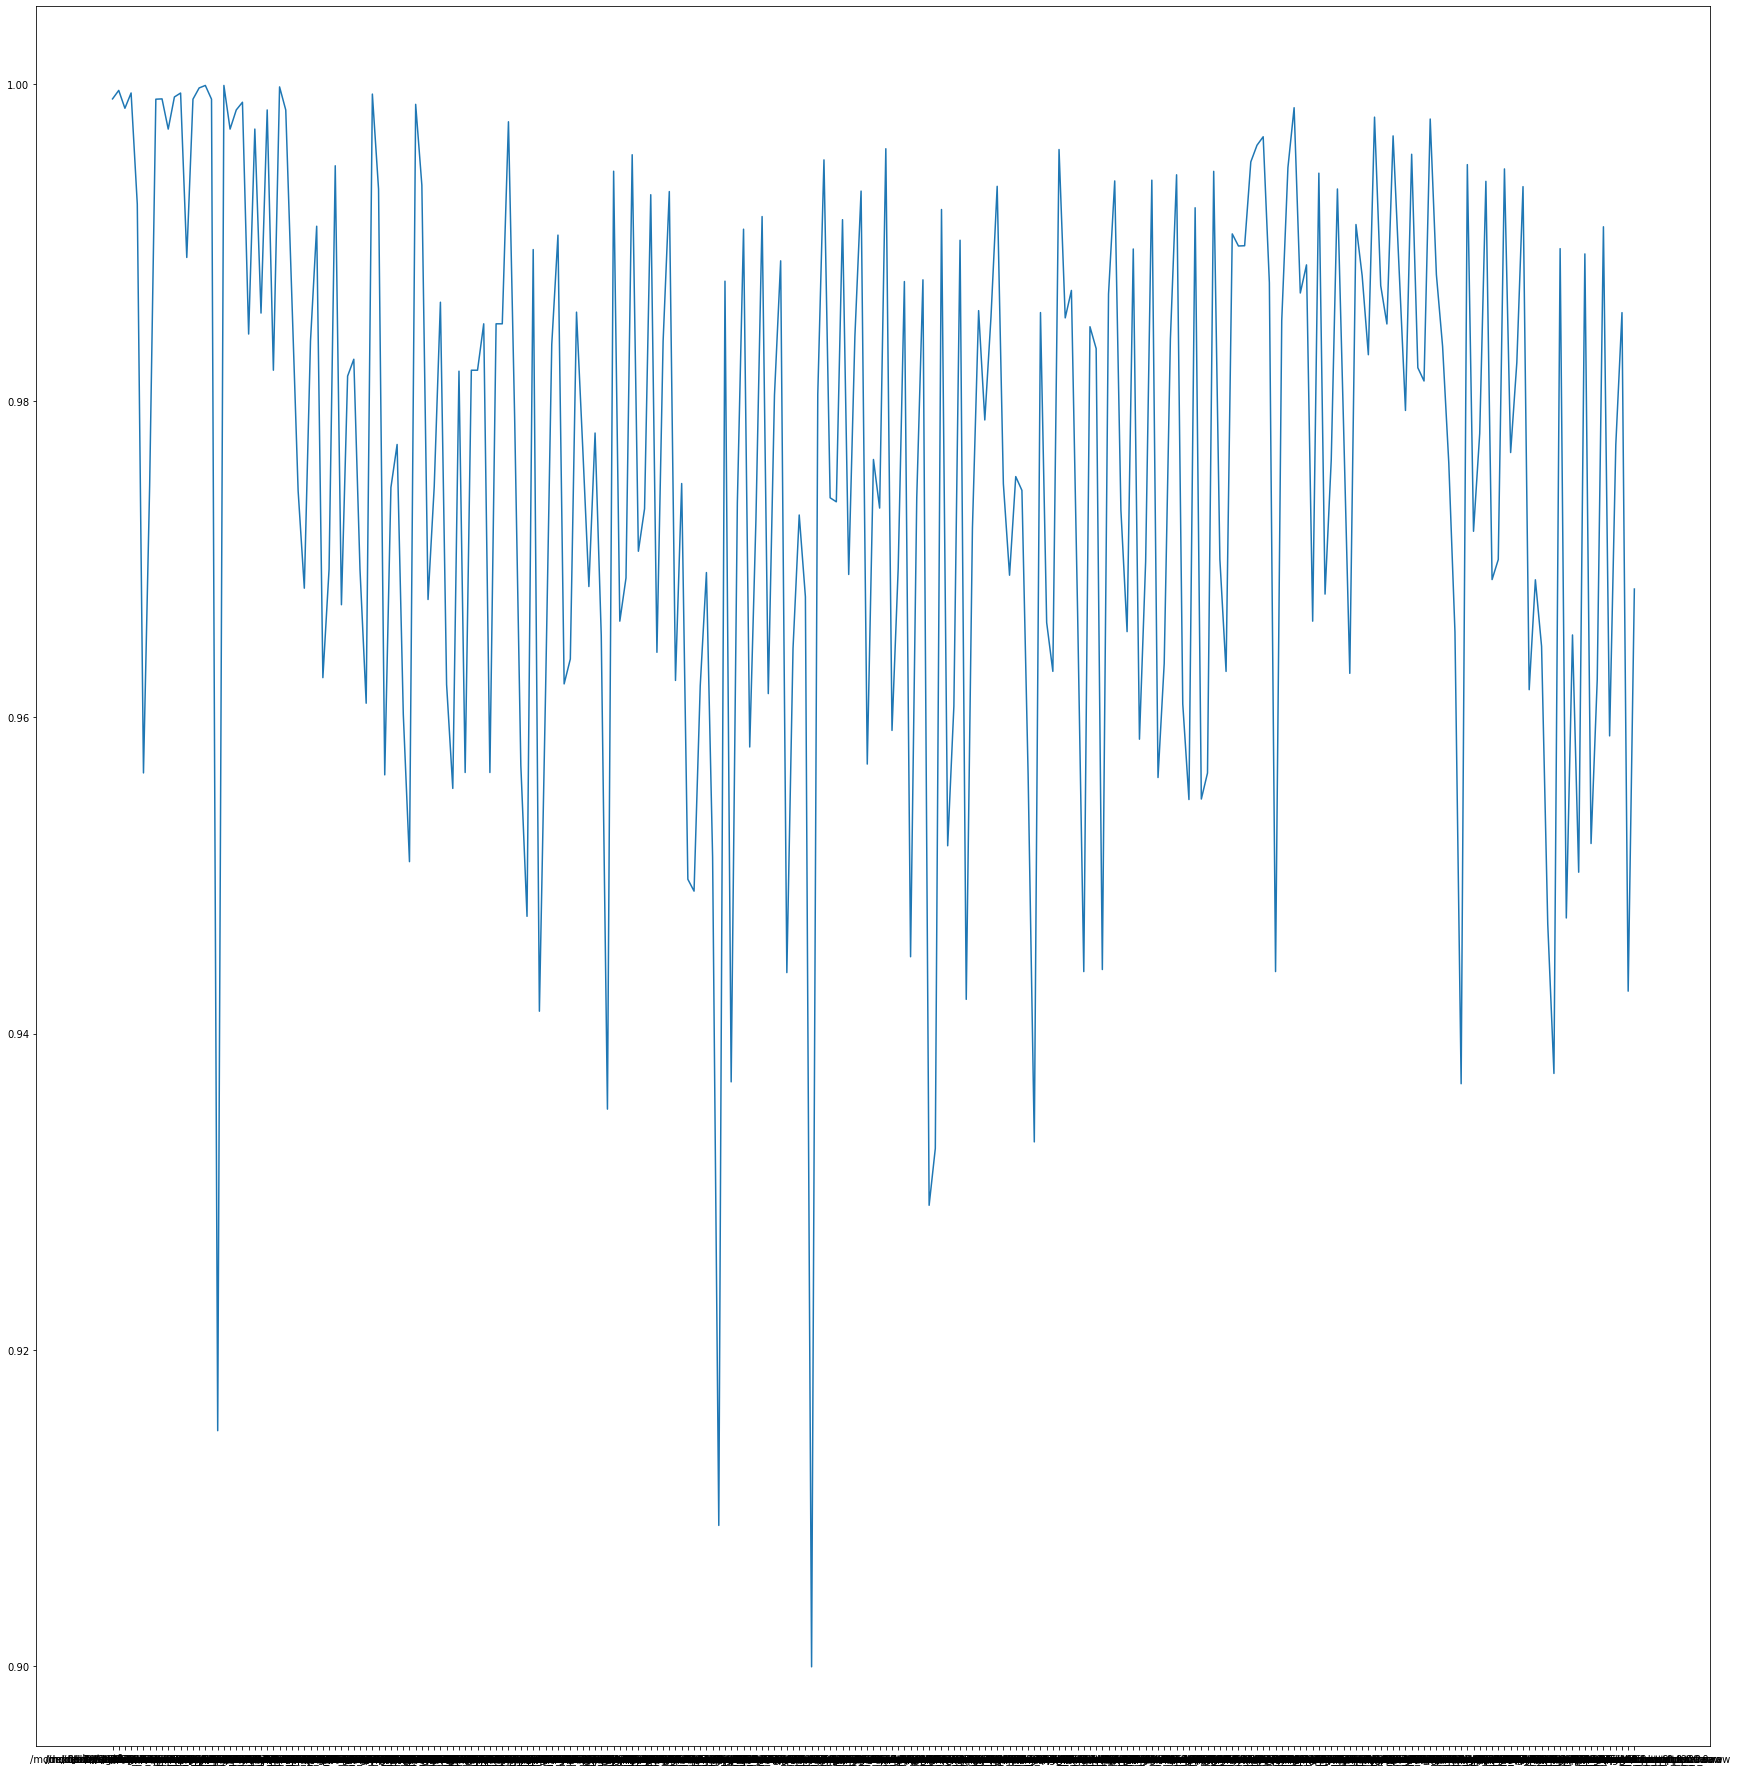

In [25]:
output_folder = 'plots_fp32_vs_int8'
os.makedirs(output_folder,exist_ok=True)
INT8_DSP = "./OUTPUT_8b_DSP/Result_0"  # int8 dsp layer dump dir path
FP32_CPU = "./OUTPUT_FP32_CPU/Result_0" # fp32 arm apu dump dir path
plot_layer_by_layer(INT8_DSP, FP32_CPU, output_folder)

* The above graph can be found in plots_fp32_vs_int8 folder. Highly recommended to open the .html graph file for better visualization.
* <b>The above graph is a cosine similarity comparision between fp32 layer vs int 8 layers.</b>
* <b>Layers which are more far from value 1 are causing accurcy drop issue.</b> Close to 1 means most similar. 
* <b>From above graph we can see that /model.22/Sigmoid has highest difference.</b>
* There could be layers like split with high similarity difference but those are math invariant layers. So, these type of layers can be avoided
* The graph will differ based on the input image for inference and input for quantization.

# Compute min, max, scale and offset for layer with high difference
#### below screenshots are clipped from output of snpe-dlc-info.

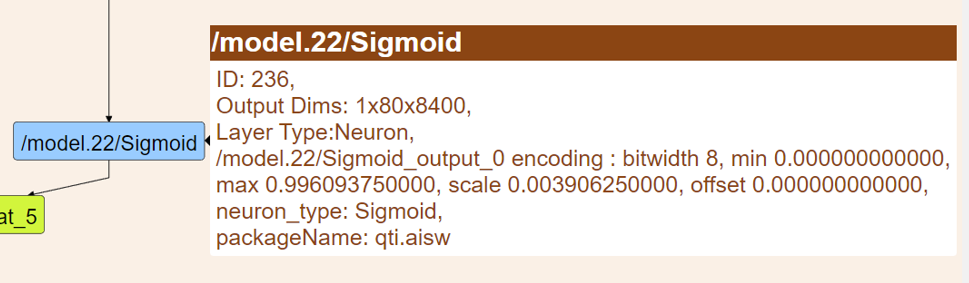

Following_next_layer
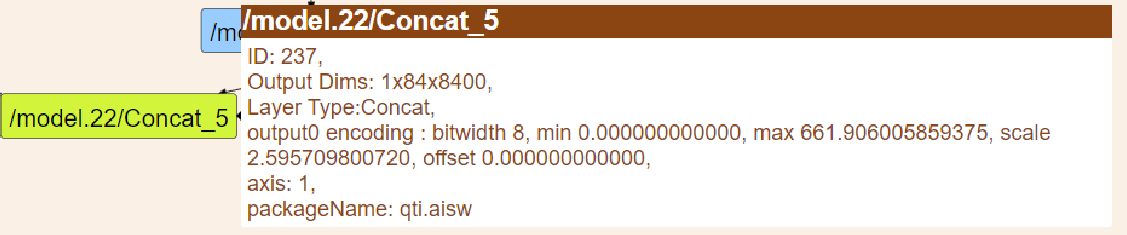

In [26]:
def get_scale_offset(min_value,max_value,bw=8):
    qmin = 0
    qmax = (2**bw)-1
    scale = (max_value - min_value) / (qmax - qmin)
    initial_zero_point = qmin - min_value / scale
    final_zero_point = 0;
    if (initial_zero_point < qmin):
        final_zero_point = qmin
    elif (initial_zero_point > qmax):
        final_zero_point = qmax
    else:
        final_zero_point = round(initial_zero_point)
    return scale,-final_zero_point


In [27]:
# Sigmoid layer
scale, offset = get_scale_offset(0.0, 0.996093750000, 16)
print("Sigmoid layer : scale:",scale," || offset:",offset )

Sigmoid layer : scale: 1.5199416342412452e-05  || offset: 0


In [39]:
# Following_layer_concat
scale, offset = get_scale_offset(0.0, 661.906005859375, 16)
print("Following_layer_concat : scale:",scale," || offset:",offset )

Following_layer_concat : scale: 0.010100038236963073  || offset: 0


###  Add both layers details to the encoding file. 
File "encoding_format.encodings" is present in current workspace

Using these encodings we are making sure that these 2 layer does not get quantized in int8 instead 16 bit format is followed.

# Create dlc and quantized dlc using new encoding file

In [40]:
os.environ['SNPE_TARGET_ARCH']="x86_64-linux-clang" #for host machine for dlc creation

In [41]:
%%bash
mkdir -p mixed_precision_dlc
cp -r dlc/quantization_raw mixed_precision_dlc
cp dlc/quantization_input_list.txt mixed_precision_dlc
export LD_LIBRARY_PATH=$SNPE_ROOT/lib/$SNPE_TARGET_ARCH:$LD_LIBRARY_PATH
export PATH=$SNPE_ROOT/bin/$SNPE_TARGET_ARCH::$PATH
export PYTHONPATH=$SNPE_ROOT/lib/python:$PYTHONPATH
export ONNX_DIR="/local/mnt/workspace/env/aimet_126/lib/python3.8/site-packages/onnx"
$SNPE_ROOT/bin/$SNPE_TARGET_ARCH/snpe-net-run --version
snpe-onnx-to-dlc --input_network onnx_model/yolov8n_11.onnx --output_path mixed_precision_dlc/yolov8_mixed_precision.dlc --quantization_overrides encoding_format.encodings 
cd mixed_precision_dlc
snpe-dlc-quantize --input_dlc yolov8_mixed_precision.dlc --override_params --output_dlc yolov8_mixed_precision_Q.dlc --input_list quantization_input_list.txt --enable_htp

SNPE v2.10.0.4541
     0.1ms [  INFO ] Initializing logging in the backend. Callback: [0xc9b6a0], Log Level: [3]
     0.1ms [  INFO ] No BackendExtensions lib provided;initializing NetRunBackend Interface
   353.6ms [  INFO ] cleaning up resources for input tensors
   353.8ms [  INFO ] cleaning up resources for output tensors
   709.8ms [  INFO ] cleaning up resources for input tensors
   709.8ms [  INFO ] cleaning up resources for output tensors
  1070.4ms [  INFO ] cleaning up resources for input tensors
  1070.4ms [  INFO ] cleaning up resources for output tensors
  1428.5ms [  INFO ] cleaning up resources for input tensors
  1428.5ms [  INFO ] cleaning up resources for output tensors
  1782.6ms [  INFO ] cleaning up resources for input tensors
  1782.6ms [  INFO ] cleaning up resources for output tensors
  2166.0ms [  INFO ] cleaning up resources for input tensors
  2166.0ms [  INFO ] cleaning up resources for output tensors
  2660.1ms [  INFO ] cleaning up resources for input tens

2023-07-20 13:22:07,966 - 214 - INFO - Processing user provided quantization encodings: 
2023-07-20 13:22:07,966 - 219 - WARNING - Can't simplify the model when custom ops or quantization overrides are specified, converting without simplification.
2023-07-20 13:22:08,096 - 219 - WARNING - WARNING_OP_VERSION_NOT_SUPPORTED: Operation Constant Not Supported. Expected operator version: [1, 9], instead got version: [11]
2023-07-20 13:22:08,096 - 219 - WARNING - WARNING_OP_VERSION_NOT_SUPPORTED: Operation Constant Not Supported. Expected operator version: [1, 9], instead got version: [11]
2023-07-20 13:22:08,102 - 219 - WARNING - WARNING_OP_VERSION_NOT_SUPPORTED: Operation Constant Not Supported. Expected operator version: [1, 9], instead got version: [11]
2023-07-20 13:22:08,102 - 219 - WARNING - WARNING_OP_VERSION_NOT_SUPPORTED: Operation Constant Not Supported. Expected operator version: [1, 9], instead got version: [11]
2023-07-20 13:22:08,136 - 219 - WARNING - WARNING_OP_VERSION_NOT_SUP

In [42]:
%%bash
find ./new_raw -name *.raw > list.txt
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL push mixed_precision_dlc/yolov8_mixed_precision.dlc /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push mixed_precision_dlc/yolov8_mixed_precision_Q.dlc /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push new_raw /data/local/tmp/$ONDEVICE_FOLDER
$DEVICE_SHELL push $TARGET_INPUT_LIST /data/local/tmp/$ONDEVICE_FOLDER

mixed_precision_dlc/yolov8_mixed_precision.dlc: 1 file pushed, 0 skipped. 107.9 MB/s (12964638 bytes in 0.115s)
mixed_precision_dlc/yolov8_mixed_precision_Q.dlc: 1 file pushed, 0 skipped. 310.5 MB/s (7288599 bytes in 0.022s)
new_raw/: 1 file pushed, 0 skipped. 120.3 MB/s (4915200 bytes in 0.039s)
list.txt: 1 file pushed, 0 skipped. 0.4 MB/s (19 bytes in 0.000s)


# Inferencing Mixed Precision DLC on DSP Runtime and FP32 DLC on CPU
* Give name of DLC in OUTPUT_DLC_QUANTIZED8 and ondevice folder

In [43]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL shell
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/data/local/tmp/snpeexample/aarch64-android-clang8.0/lib
export PATH=$PATH:/data/local/tmp/snpeexample/aarch64-android-clang8.0/bin
export OUTPUT_FOLDER=OUTPUT_8b_DSP_MX_PR
export OUTPUT_FOLDER_FP32=OUTPUT_FP32_CPU_MX_PR
export OUTPUT_DLC_QUANTIZED8=yolov8_mixed_precision_Q.dlc
export OUTPUT_DLC_FP32=yolov8_mixed_precision.dlc
export ADSP_LIBRARY_PATH="/data/local/tmp/snpeexample/dsp/lib;/system/lib/rfsa/adsp;/system/vendor/lib/rfsa/adsp;/dsp"
export ONDEVICE_FOLDER="yolov8_comparision"

cd /data/local/tmp/$ONDEVICE_FOLDER &&
snpe-net-run --container $OUTPUT_DLC_FP32 --input_list list.txt --output_dir $OUTPUT_FOLDER_FP32 --debug
snpe-net-run --container $OUTPUT_DLC_QUANTIZED8 --input_list list.txt --output_dir $OUTPUT_FOLDER --use_dsp --debug

-------------------------------------------------------------------------------
Model String: N/A
SNPE v2.10.0.4541
-------------------------------------------------------------------------------
Processing DNN input(s):
./new_raw/img1.raw
Successfully executed!
-------------------------------------------------------------------------------
Model String: N/A
SNPE v2.10.0.4541
-------------------------------------------------------------------------------
Processing DNN input(s):
./new_raw/img1.raw
Successfully executed!


# Pulling Output folder generated for different precision and runtimes

In [44]:
%%bash
export DEVICE_SHELL="adb -H $DEVICE_HOST -s $DEVICE_ID"
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_8b_DSP_MX_PR OUTPUT_8b_DSP_MX_PR
$DEVICE_SHELL pull /data/local/tmp/$ONDEVICE_FOLDER/OUTPUT_FP32_CPU_MX_PR OUTPUT_FP32_CPU_MX_PR

/data/local/tmp/yolov8_comparision/OUTPUT_8b_DSP_MX_PR/: 251 files pulled, 0 skipped. 37.7 MB/s (259467912 bytes in 6.561s)
/data/local/tmp/yolov8_comparision/OUTPUT_FP32_CPU_MX_PR/: 249 files pulled, 0 skipped. 38.0 MB/s (256637976 bytes in 6.448s)


In [45]:
output_folder = "OUTPUT_8b_DSP_MX_PR/Result_0"
output = np.fromfile(output_folder+'/output0.raw', dtype="float32")
output = np.transpose(output.reshape((84,8400)).astype(np.float32) )
# for i in range(0,8400):
#     if any(y > 0.00990131 for y in output[i][4:]):
#         print(output[i][4:])

originalImagePath = inference_file_name.replace(".raw",".jpg").replace("raw","val2017")

runtime = output_folder.split("_")[-1]
save_img_path = output_folder+"/"+inference_file_name.split("/")[-1].replace(".raw",".jpg")

label_and_coordinates = post_proc(output, originalImagePath, save_img_path)

print("\n=======================\nprediction :: \n",label_and_coordinates)
# class_name, probability, 4 coordinates.

val2017/img1.jpg

prediction :: 
 mouse 0.9494035243988037 406 435 456 479
laptop 0.8989033699035645 0 300 280 520
bottle 0.8686032295227051 320 304 380 480
sports 0.43430161476135254 500 336 606 406
laptop 0.43430161476135254 110 166 550 354
remote 0.37370139360427856 534 452 572 518
keyboard 0.37370139360427856 76 515 464 585


In [46]:
print(originalImagePath)
print(save_img_path)

val2017/img1.jpg
OUTPUT_8b_DSP_MX_PR/Result_0/img1.jpg


INPUT


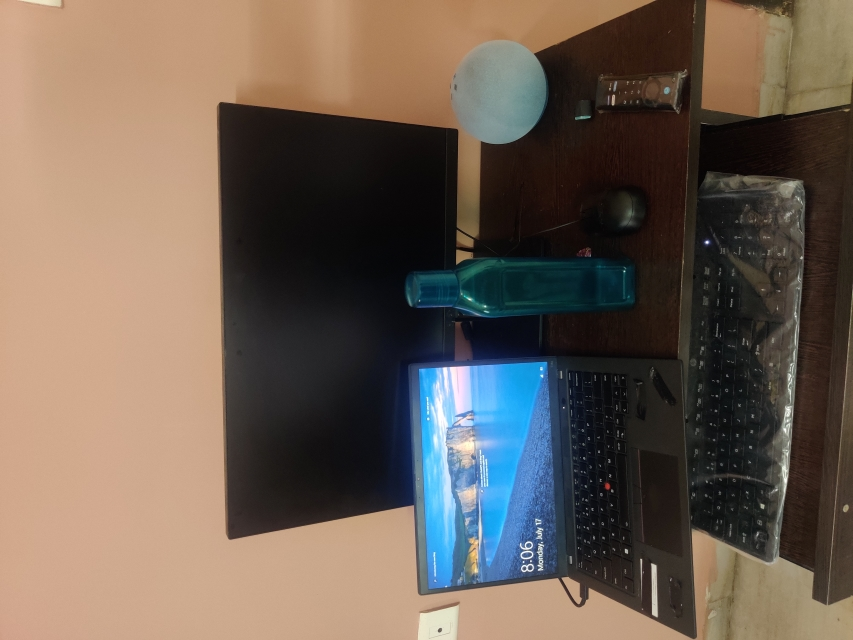


OUTPUT


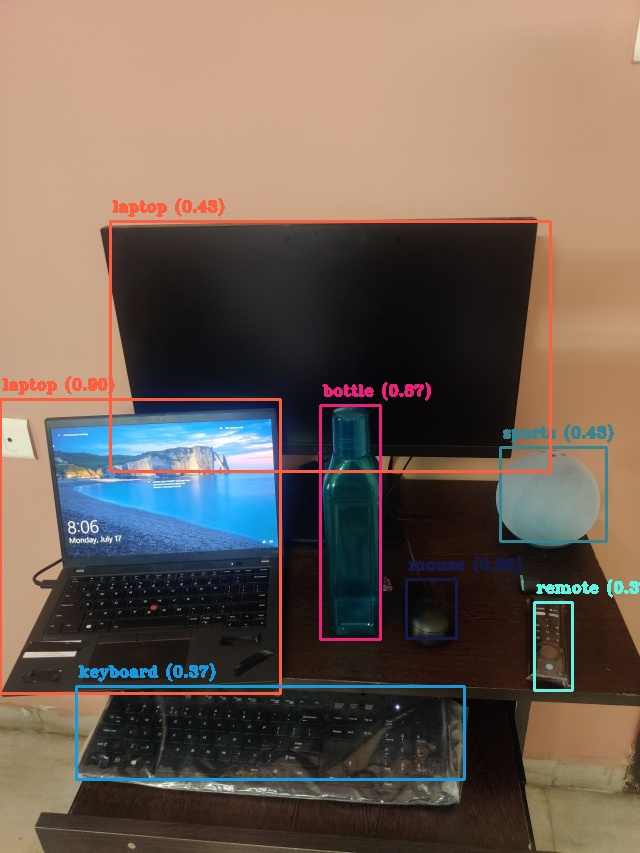

In [47]:
print("INPUT")
display(Image(filename=originalImagePath))
print("\n=========================================\nOUTPUT")
display(Image(filename=save_img_path))

In [49]:
# output_folder = 'mixed_precision_plots_fp32_vs_int8'
# os.makedirs(output_folder,exist_ok=True)
# INT8_DSP = "./OUTPUT_8b_DSP_MX_PR/Result_0"  # int8 dsp layer dump dir path
# FP32_CPU = "./OUTPUT_FP32_CPU_MX_PR/Result_0" # fp32 arm apu dump dir path
# plot_layer_by_layer(INT8_DSP, FP32_CPU, output_folder)
# print("open the html >> mixed_precision_plots_fp32_vs_int8/cosine_plot.html for better scale visualization")

# INT8 output vs MIXED_PRECISION output

INT_8 output


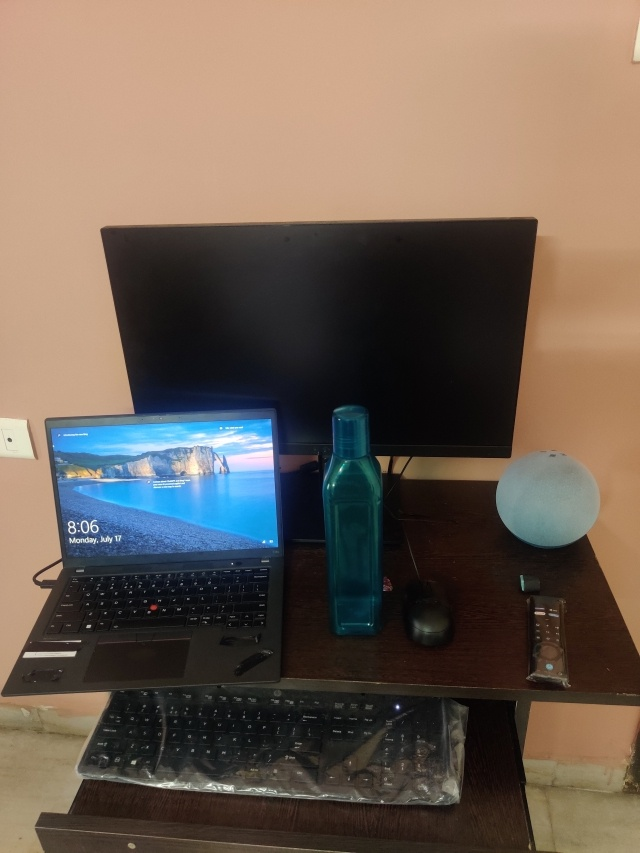


MIXED_PRECISION OUTPUT


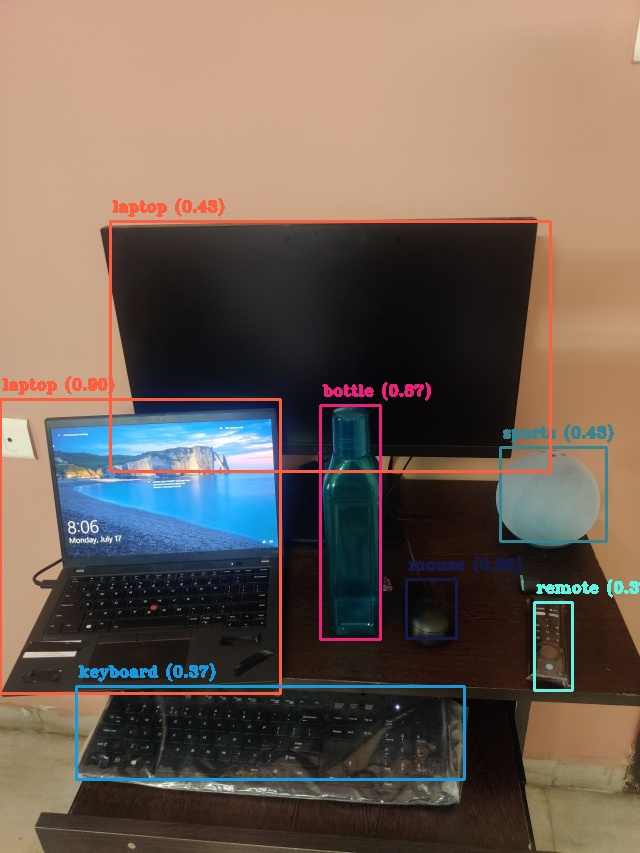

In [50]:
print("INT_8 output")
display(Image(filename="OUTPUT_8b_DSP/Result_0/img1.jpg"))
print("\n=========================================\nMIXED_PRECISION OUTPUT")
display(Image(filename="OUTPUT_8b_DSP_MX_PR/Result_0/img1.jpg"))